## MLC HW 4

### Question 1 (40 points)

In this question, you will model traffic counts in Pittsburgh using Gaussian process (GP) regression.  The included dataset, "PittsburghTrafficCounts.csv", represents the average daily traffic counts computed by traffic sensors at over 1,100 locations in Allegheny County, PA.  The data was collected from years 2012-2014 and compiled by Carnegie Mellon University’s Traffic21 Institute; we have the longitude, latitude, and average daily count for each sensor.  

Given this dataset, your goal is to learn a model of traffic count as a function of spatial location.  To do so, fit a Gaussian Process regression model to the observed data.  While you can decide on the precise kernel specification, you should try to achieve a good model fit, as quantified by a log marginal likelihood value greater than (i.e., less negative than) -1400.  Here are some hints for getting a good model fit:

* We recommend that you take the logarithm of the traffic counts, and then subtract the mean of this vector, before fitting the model.

* Since the data is noisy, don't forget to include a noise term (WhiteKernel) in your model.

* When fitting a GP with RBF kernel on multidimensional data, you can learn a separate length scale for each dimension, e.g., length_scale=(length_scale_x, length_scale_y). 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel
from sklearn.model_selection import train_test_split
np.random.seed(42)
Data1=pd.read_csv("PittsburghTrafficCounts.csv")
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount
0,-80.278366,40.468606,84.0
1,-80.162117,40.384598,95.0
2,-80.221205,40.366778,97.0
3,-80.142455,40.622084,111.0
4,-80.131975,40.544915,125.0


In [2]:
# Create a normalized column to create a better-fitting model
Data1['NormalizedDailyTrafficCount'] = np.log(Data1['AvgDailyTrafficCount'])
Data1['NormalizedDailyTrafficCount'] = Data1['NormalizedDailyTrafficCount'] - \
                                       Data1['NormalizedDailyTrafficCount'].mean()
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount,NormalizedDailyTrafficCount
0,-80.278366,40.468606,84.0,-3.977526
1,-80.162117,40.384598,95.0,-3.854466
2,-80.221205,40.366778,97.0,-3.833632
3,-80.142455,40.622084,111.0,-3.698812
4,-80.131975,40.544915,125.0,-3.580029


1) The kernel after parameter optimization and fitting to the observed data. (10 pts)

In [3]:
x_obs = Data1[['Longitude', 'Latitude']]
y_obs = Data1['NormalizedDailyTrafficCount']

X_train, X_test, y_train, y_test = train_test_split(x_obs, y_obs, test_size=0.2, random_state=42)

In [4]:
kernel = 1.* RBF(length_scale=1., length_scale_bounds=(1e-3, 1e3)) \
    + WhiteKernel(noise_level=1., noise_level_bounds=(1e-10, 1e10))

gp = GaussianProcessRegressor(kernel=kernel,random_state=42)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X_train, y_train)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=42)

2) The log marginal likelihood of the training data. (5 pts)

In [5]:
print ("Log maginal likelihood of the training data:", gp.log_marginal_likelihood_value_)

Log maginal likelihood of the training data: -1096.7940714971376


3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10 pts)

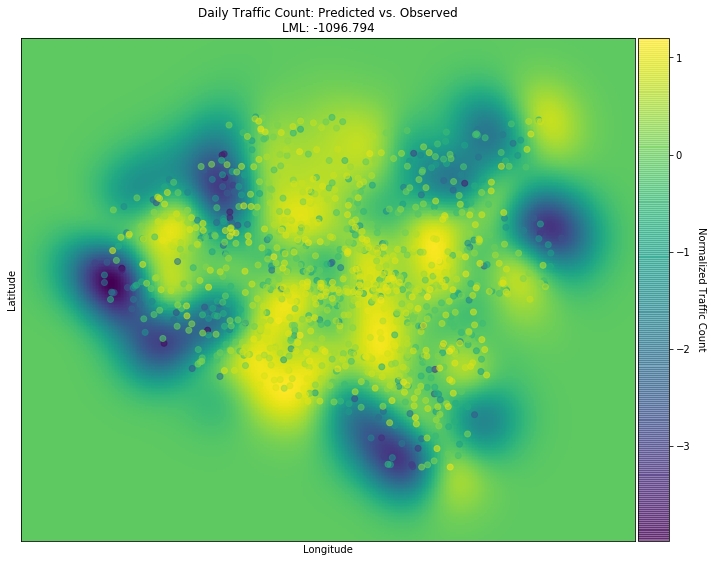

In [6]:
x_min, x_max = Data1['Longitude'].min() - 0.1, Data1['Longitude'].max() + 0.1
y_min, y_max = Data1['Latitude'].min() - 0.1,  Data1['Latitude'].max() + 0.1
h = .002  # step size in the mesh

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

plt.figure(figsize=(10, 10))
    # Plot the predicted probabilities. For that, we will assign a color to
    # each point in the mesh [x_min, m_max]x[y_min, y_max].
plt.subplot(1, 1, 1)
Z = gp.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape((xx.shape[0], xx.shape[1]))
plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower", cmap='viridis')
# Plot also the training points
plot1 = plt.scatter(Data1['Longitude'], Data1['Latitude'], c=Data1['NormalizedDailyTrafficCount'],
            cmap='viridis', alpha=0.6)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('Daily Traffic Count: Predicted vs. Observed\nLML: {0:.3f}'.format(gp.log_marginal_likelihood_value_))

#colorbar
ax = plt.gca()
im = ax.imshow(np.arange(100).reshape((10,10)))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(plot1, cax=cax)
cbar.set_label('Normalized Traffic Count', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5 pts)

In [7]:
Data1['PredictedTrafficCount'] = gp.predict(Data1[['Longitude', 'Latitude']])

stdev = Data1['PredictedTrafficCount'].std()
Data1['two_stdevs'] = (Data1['NormalizedDailyTrafficCount'] - Data1['PredictedTrafficCount']) / (2 * stdev)
Data1['two_stdevs_bool'] = [1 if i > 2 else -1 if i < -2 else 0 for i in Data1['two_stdevs']]
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount,NormalizedDailyTrafficCount,PredictedTrafficCount,two_stdevs,two_stdevs_bool
0,-80.278366,40.468606,84.0,-3.977526,-1.556430,-2.332443,-1
1,-80.162117,40.384598,95.0,-3.854466,-1.099913,-2.653690,-1
2,-80.221205,40.366778,97.0,-3.833632,-1.563239,-2.187258,-1
3,-80.142455,40.622084,111.0,-3.698812,-1.141666,-2.463512,-1
4,-80.131975,40.544915,125.0,-3.580029,-1.140086,-2.350599,-1


In [8]:
total_count = Data1['two_stdevs_bool'].count()
two_stdevs_lower = Data1[Data1['two_stdevs_bool'] == -1]['two_stdevs_bool'].count()
two_stdevs_higher = Data1[Data1['two_stdevs_bool'] == 1]['two_stdevs_bool'].count()
print('Percentage outside of 2 st. devs from model prediction: {0:.3f}%'\
      .format(100 * (two_stdevs_lower + two_stdevs_higher) / total_count))

Percentage outside of 2 st. devs from model prediction: 1.794%


5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)

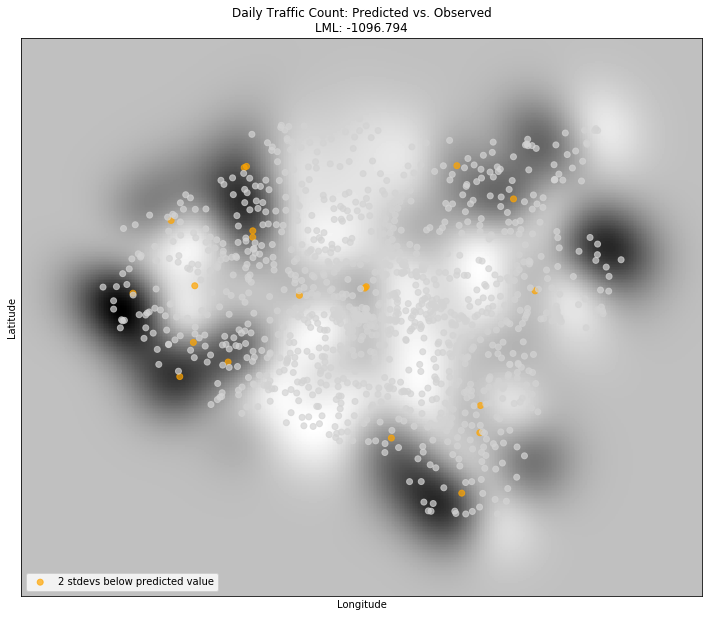

In [9]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
Z = gp.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape((xx.shape[0], xx.shape[1]))
plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower", cmap='gray')

# Plot also the training points
plt.scatter(Data1['Longitude'], Data1['Latitude'], 
            c=np.array(["lightgray", "g", 'orange'])[Data1['two_stdevs_bool']], 
            alpha=0.7, label='2 stdevs below predicted value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('Daily Traffic Count: Predicted vs. Observed\nLML: {0:.3f}'\
          .format(gp.log_marginal_likelihood_value_))
plt.legend(loc=3)

plt.tight_layout()
plt.show()

### Question 2: Cluster-based anomaly detection (10 points)

Given an unlabeled dataset with two real-valued attributes, we perform cluster-based anomaly detection by running k-means, choosing the number of clusters k automatically using the Schwarz criterion.  Four clusters are formed:

A: 100 points, center (0, 0), standard deviation 0.1

B: 150 points, center (35, 5), standard deviation 5

C: 2 points, center (15, 20), standard deviation 1

D: 200 points, center (10, 10), standard deviation 1

Given the four points below, which of these points are, and are not, likely to be anomalies?  Choose “Anomaly” or “Not Anomaly”, and provide a brief explanation, for each point. 
(Hint: your answers should take into account the size and standard deviation of each cluster as well as the distances to cluster centers.)

(1, 0)		**Anomaly** / Not Anomaly <br>Using global density-based anomoly detection, this point would not be anomalous (as distance-wise it is very close to a dense pack); yet using local-based anomoly detection, it is very anomalous, falling 10 st devs outside of the nearest cluster center. 


(35, 2)		Anomaly / **Not Anomaly**  <br>While it is farther away from the nearest cluster center than the point above, this cluster is much less dense, and this point falls within one st dev of the center, and is unlikely to be an anomoly.


(15, 19)	**Anomaly** / Not Anomaly  <br>This point, like the point above, is within a st dev of the cluster center, but there are only two points in the cluster! Given the larger size of all of the other clusters, all points in this tiny cluster are likely to be marked anomalous.


(10, 11)	Anomaly / **Not Anomaly**  <br>Within 1 st dev of a fairly dense cluster center, and thus not likely to be marked anomalous.


#### Your solution here

### Question 3: Anomaly detection (50 points)

For this question, use the "County Health Indicators" dataset provided to identify the most anomalous counties. Please list the top 5 most anomalous counties computed using each of the following models.  (We recommend that, as a pre-processing step, you drop na values, and make sure all numeric values are treated as floats not strings.)

In [10]:
Data2=pd.read_csv("2016CountyHealthIndicators.csv")
Data2.dropna(inplace=True)
Data2.set_index('County', inplace=True)
Data2 = Data2.convert_objects(convert_numeric=True)
Data2.head()

/Users/alexandershannon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  after removing the cwd from sys.path.


,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise','\% Excessive Drinking',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
County,,,,,,,,,,,,,,,,,,,,,
"Autauga, Alabama",19.0,4.4,4.3,9.0,19.0,31,7.1,29,71.0,15.0,...,18.0,4.3,27.0,13.8,254.0,76.0,12.9,14,89.0,42.0
"Baldwin, Alabama",16.0,4.1,4.2,9.0,19.0,27,7.6,25,72.0,15.0,...,20.0,4.5,28.0,12.0,221.0,70.0,13.1,15,84.0,37.0
"Barbour, Alabama",26.0,4.9,4.7,12.0,21.0,41,5.1,33,45.0,12.0,...,38.0,5.3,54.0,8.1,147.0,64.0,12.6,18,84.0,35.0
"Bibb, Alabama",22.0,4.8,4.6,12.0,21.0,40,7.4,33,33.0,14.0,...,27.0,4.3,32.0,9.8,236.0,75.0,12.9,13,84.0,46.0
"Blount, Alabama",21.0,4.6,4.5,7.0,19.0,32,8.3,29,26.0,14.0,...,24.0,4.1,28.0,8.5,219.0,89.0,12.7,12,85.0,59.0


Part 1: Learn a Bayesian network structure using only the six features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"].  Use pd.cut() to discretize each feature into 5 categories: 0,1,2,3,4. 

In [11]:
Data3 = Data2[["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'",
               "'\% Children in Poverty'","'Average Daily PM2.5'"]]

def discretize_columns(df, N):
    '''
    discretizes columns into N discrete values
    '''
    for column in df.columns:
        df[column] = pd.cut(df[column], N)
    df.dropna(inplace=True)

    for column in df.columns:
        discrete_cat = dict(zip(df[column].unique(), range(len(df[column].unique()))))
        df[column].replace(discrete_cat, inplace=True)
        
    return df

Data3 = discretize_columns(Data3, 5)        
Data3.head()

/Users/alexandershannon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/alexandershannon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/alexandershannon/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5'
County,,,,,,
"Autauga, Alabama",0,0,0,0,0,0
"Baldwin, Alabama",0,0,0,0,0,0
"Barbour, Alabama",1,1,0,0,1,0
"Bibb, Alabama",1,1,0,0,0,0
"Blount, Alabama",0,0,0,1,0,0


(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts) 

In [12]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore

np.random.seed(42)
hc = HillClimbSearch(Data3, scoring_method=BicScore(Data3))
best_model = hc.estimate()
print("Bayesian Network Structure:")
for edge in best_model.edges():
    print(edge)

Bayesian Network Structure:
("'Violent Crime Rate'", "'80/20 Income Ratio'")
("'80/20 Income Ratio'", "'Average Daily PM2.5'")
("'80/20 Income Ratio'", "'\\% Children in Poverty'")
("'80/20 Income Ratio'", "'\\% Obese'")
("'80/20 Income Ratio'", "'\\% Smokers'")


(b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)

In [13]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator

model = BayesianModel(best_model.edges())
model.fit(Data3, estimator=MaximumLikelihoodEstimator)

def LL(x,model,verbose=False):
    '''
    Log-likelihood of data record x given model
    '''
    loglike = 0
    for cpd in model.get_cpds():
        temp_cpd = cpd.copy()
        thevariable = temp_cpd.variable
        theparents = model.predecessors(thevariable)
        for parent in theparents:
            temp_cpd.reduce([(parent, x[parent])])
        theprob = temp_cpd.get_values()[x[thevariable],0]
        if verbose:
            print (thevariable,theparents,theprob)
        loglike += np.log(theprob)
    return loglike

exmp=Data3.apply(lambda x: LL(x,model),axis=1)
print ('Counties with Lowest Log-Likelihood (Top 5):')
print (exmp.sort_values().head(5))

Counties with Lowest Log-Likelihood (Top 5):
County
St. Louis City, Missouri   -15.123167
Crittenden, Arkansas       -15.123167
Iberville, Louisiana       -13.251365
Phillips, Arkansas         -13.251365
Shelby, Tennessee          -13.251365
dtype: float64


Part 2: Cluster based anomaly detection.  Use all numeric features for this part, and do not discretize. 

(a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)

In [14]:
from sklearn.cluster import KMeans

# fit k-means
KM=KMeans(n_clusters=3,random_state=999)
scor=KM.fit_predict(Data3)

# distance to each cluster center
res=pd.DataFrame(KM.transform(Data3))
res.set_index(Data3.index, inplace=True)

# calculate the nearest cluster center
res['nearest_dist'] = res.min(axis=1)
res['nearest_cluster_center'] = res.idxmin(axis=1)
top_5_k_means = res.sort_values('nearest_dist', ascending=False).head()
top_5_k_means

,0,1,2,nearest_dist,nearest_cluster_center
County,,,,,
"District of Columbia, District of Columbia",5.003692,4.753073,5.338256,4.753073,1
"San Francisco, California",4.561798,5.811318,4.650616,4.561798,0
"New York, New York",5.424828,5.206387,4.467938,4.467938,2
"Routt, Colorado",4.856241,6.066378,4.461876,4.461876,2
"Philadelphia, Pennsylvania",4.654380,4.458471,4.569307,4.458471,1


(b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)

In [15]:
from sklearn.mixture import GaussianMixture
GM=GaussianMixture(n_components=3,random_state=999)
GM.fit(Data3)

GM_log_likelihood = pd.DataFrame(GM.score_samples(Data3), index=Data3.index)
GM_log_likelihood.rename(columns={0: 'log-likelihood'}, inplace=True)
top_5_gaus_mix = GM_log_likelihood.sort_values('log-likelihood')[:5]
top_5_gaus_mix 

,log-likelihood
County,
"Davidson, Tennessee",-32.087241
"Philadelphia, Pennsylvania",-31.883376
"New York, New York",-29.991267
"San Francisco, California",-29.447257
"District of Columbia, District of Columbia",-27.739834


Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose.  (10 pts)

In [16]:
from sklearn.ensemble import IsolationForest

# fit the model
clf = IsolationForest(max_samples=100, random_state=42)
clf.fit(Data3)

clf_avg_anomaly_score = pd.DataFrame(clf.decision_function(Data3), index=Data3.index)
clf_avg_anomaly_score.rename(columns={0: 'avg_anomaly_score'}, inplace=True)
top_5_iso_forest = clf_avg_anomaly_score.sort_values('avg_anomaly_score')[:5]
top_5_iso_forest

,avg_anomaly_score
County,
"San Francisco, California",-0.169338
"New York, New York",-0.155467
"Boulder, Colorado",-0.143695
"Routt, Colorado",-0.142120
"St. Louis City, Missouri",-0.137300


Part 4: Compare and contrast the results from the different models.  Were there some counties that were found to be anomalous in some models and not in others?  Please provide some intuitions on why each county was found to be anomalous. (5 pts)

In [17]:
k_means = top_5_k_means['nearest_dist'].to_frame()
gaus_mix = top_5_gaus_mix
iso_forest = top_5_iso_forest
comparison = k_means.join(gaus_mix, how='outer').join(iso_forest, how='outer')
column_replace = dict(zip(comparison.columns, ['k_means', 'gaus_mix', 'iso_forest']))
comparison.rename(columns=column_replace, inplace=True)
comparison

,k_means,gaus_mix,iso_forest
County,,,
"Boulder, Colorado",NaN,NaN,-0.143695
"Davidson, Tennessee",NaN,-32.087241,NaN
"District of Columbia, District of Columbia",4.753073,-27.739834,NaN
"New York, New York",4.467938,-29.991267,-0.155467
"Philadelphia, Pennsylvania",4.458471,-31.883376,NaN
"Routt, Colorado",4.461876,NaN,-0.142120
"San Francisco, California",4.561798,-29.447257,-0.169338
"St. Louis City, Missouri",NaN,NaN,-0.137300


**Discussion:**<br>

All of the counties, with the exception of Routt and Boulder, are major metropolitan areas. Boulder and Routt are unique in their own right, as Routt is home to Steamboat Springs resort and ski area, and Boulder is a major college town near Denver. (Davidson, TN is the county in which Nashville is located).<br>

New York and San Francisco are the only two in the top 5 for all three models; this is not terribly surprising, as these tend to be some of the most affluent cities in the country (and also have high rates of homelessness). Philadelphia are also in this tier, but in a slightly less-pronounced way. They may not have made the top 5, but likely would be in the top 10 for all three models.<br>

It is interesting that Routt, CO is picked up by both K_means and Isolation Forest models, as it is significantly different from the other counties listed (an anomaly among anomolies!). Possible reasons for this would require further investigation as to the properties of Routt.